#Tomato Leaf Disease prediction using transfer learning of Inception V3

Download dataset and store it in google drive :
 https://www.kaggle.com/noulam/tomato

- First change notebook runtime type to GPU
- click on the folder icon on left and click drive icon to  - mount your google drive
- After drive is mounted we get a drive folder
- Navigate to folder you need for dataset. Right click and  - copy path of dataset folder




Tomato Leaf Disease
![picture]( https://docs.google.com/uc?export=download&id=1DxRsDu0tHm8ziQpWZgB1g78Q76ehPXtR)

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 54kB/s 


In [3]:
# check the GPU assigned by executing the command 

!nvidia-smi

Mon Sep  7 15:19:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Colab Notebooks/Tomato_Leaf_Dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/Tomato_Leaf_Dataset/test'


Inception-v3 is a convolutional neural network that is 48 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

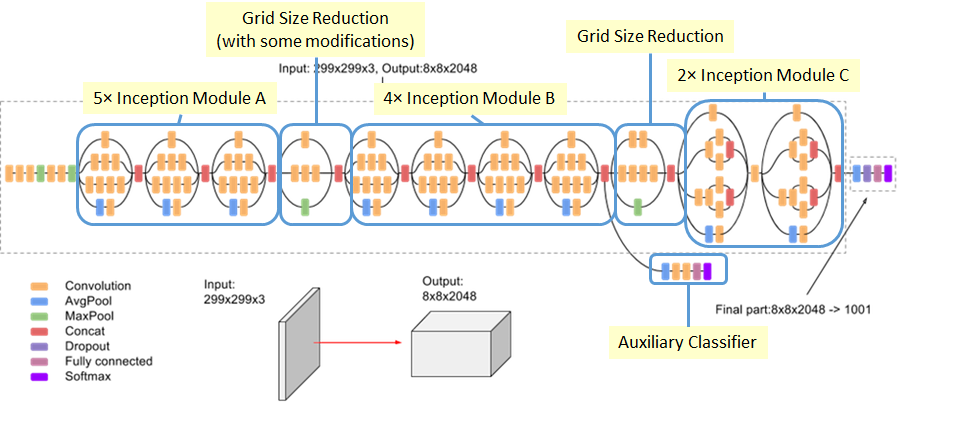

In [9]:
#Import the Inception V3 library as shown below. We will be using imagenet weights
#include_top = False is set since we do not want our first and last layers from the original V3net

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


87916544/87910968 [==============================] - 1s 0us/step


In [10]:
# don't train existing weights .All are pretrained. 
for layer in inception.layers:
    layer.trainable = False

In [11]:
  # useful for getting number of output classes
folders = glob('/content/drive/My Drive/Colab Notebooks/Tomato_Leaf_Dataset/train/*')

In [12]:
#our layers - you can add more if you want
x = Flatten()(inception.output)

In [13]:
#add last layer with no of folders in train(no of output classes). If multiple classes use softmax activation or binary use sigmoid
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
# Use the Image Data Generator to import the images from the dataset. For test data only rescale. No need to do other changes,
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Tomato_Leaf_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18364 images belonging to 10 classes.


In [18]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Tomato_Leaf_Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5510 images belonging to 10 classes.


In [19]:
print(len(training_set),  len(test_set))

574 173


In [20]:
import sys
print(sys.version)

3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [21]:
# fit the model.  Run the cell. It will take some time to execute

 
r = model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=2,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
    )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
574/574 [==============================] - 9912s 17s/step - loss: 2.8394 - accuracy: 0.6844 - val_loss: 1.6203 - val_accuracy: 0.8091
Epoch 2/2
574/574 [==============================] - 248s 432ms/step - loss: 2.1835 - accuracy: 0.7886 - val_loss: 2.3654 - val_accuracy: 0.7982


We can see that for every  step in each epoch the loss reduces and accuracy increases.
For single epoch ..it took two hours in colab with Tesla T4 GPU.


In [1]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_resnet50.h5')

In [ ]:
img_data

In [ ]:
img=image.load_img('Datasets/Test/Coffee/download (2).jpg',target_size=(224,224))

In [ ]:
x=image.img_to_array(img)
x

In [ ]:
x.shape

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

In [ ]:
model.predict(img_data)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
a==1